# ☕ Café  Demand Forecasting

## Victor Leiva Espinoza

## 📌 Introduction
This project focuses on building a predictive model to estimate the daily demand for each product sold at a café that specializes in Indian snacks. By analyzing historical transaction data, we aim to forecast the quantity of each item expected to be sold on a given day. This can support inventory planning, staffing, and promotional strategies.

---

## 📊 Dataset Description
The dataset, sourced from Kaggle, contains transactional records from a café offering items like samosas, chai, lassi, and Mom’s Magic biscuits. It includes two main CSV files:

- **Order Details (`order_items.csv`)**
  - `id`: Unique identifier for each entry
  - `order_id`: Order number
  - `product_id`: Identifier for the purchased item
  - `quantity`: Number of units purchased
  - `total`: Total price (unit price × quantity)
  - `created_at`: Timestamp of the transaction

- **Product Pricing (`products.csv`)**
  - `Item`: Name of the product
  - `Price`: Fixed unit price

The data spans from **April 21, 2025 to June 19, 2025**, capturing over 9,000 transactions.

The Dataset can be found here: https://www.kaggle.com/datasets/ajayjaat/caf-order-transactions-dataset?select=order_2+%281%29.csv

---

## 🎯 Objective
The goal is to develop a machine learning model that predicts the number of units expected to be sold for each product on a future date.

- Aggregating historical sales data by day and product
- Engineering temporal and trend-based features
- Training regression models (e.g., XGBoost, LightGBM)
- Evaluating performance using time-aware validation techniques

The final output will be a daily forecast table listing each product and its expected sales volume.

In [ ]:
import kagglehub
import pandas as pd
from itertools import product
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

import numpy as np

# Download latest version
path = kagglehub.dataset_download("ajayjaat/caf-order-transactions-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/caf-order-transactions-dataset


In [ ]:
df_order=pd.read_csv(path+"/order_2 (1).csv")
df_product=pd.read_csv(path+"/product.csv")

In [ ]:
print("Order INFO:\n"+ 25*"-")
display(df_order.describe())
display(df_order.info())
display(df_order.head())
display(df_order.tail())

Order INFO:
-------------------------


,id,order_id,product_id,quantity,total
count,7383.000000,7383.000000,7383.000000,7383.000000,7383.000000
mean,3714.249086,1635.118786,13.101449,2.009346,39.116213
std,2139.471157,954.601057,12.148382,2.392142,43.203645
min,15.000000,10.000000,2.000000,1.000000,5.000000
25%,1860.500000,792.500000,3.000000,1.000000,20.000000
50%,3714.000000,1619.000000,8.000000,1.000000,30.000000
75%,5568.500000,2478.000000,18.000000,2.000000,40.000000
max,7418.000000,3299.000000,52.000000,42.000000,1600.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7383 entries, 0 to 7382
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7383 non-null   int64 
 1   order_id    7383 non-null   int64 
 2   product_id  7383 non-null   int64 
 3   quantity    7383 non-null   int64 
 4   total       7383 non-null   int64 
 5   updated_at  7383 non-null   object
 6   created_at  7383 non-null   object
dtypes: int64(5), object(2)
memory usage: 403.9+ KB


None

,id,order_id,product_id,quantity,total,updated_at,created_at
0,15,10,2,1,15,2025-04-21 13:56:11,2025-04-21 13:56:11
1,16,10,3,2,20,2025-04-21 13:56:11,2025-04-21 13:56:11
2,17,11,2,2,30,2025-04-21 13:57:34,2025-04-21 13:57:34
3,18,11,3,2,20,2025-04-21 13:57:34,2025-04-21 13:57:34
4,19,12,2,2,30,2025-04-21 13:58:15,2025-04-21 13:58:15


,id,order_id,product_id,quantity,total,updated_at,created_at
7378,7414,3295,11,1,35,2025-06-19 16:37:39,2025-06-19 16:37:39
7379,7415,3296,11,1,35,2025-06-19 16:38:29,2025-06-19 16:38:29
7380,7416,3297,8,1,60,2025-06-19 16:39:40,2025-06-19 16:39:40
7381,7417,3298,8,1,60,2025-06-19 16:41:29,2025-06-19 16:41:29
7382,7418,3299,3,3,30,2025-06-19 16:45:35,2025-06-19 16:45:35


In [ ]:
print("Product INFO:\n"+ 25*"-")
display(df_product.describe())
display(df_product.info())
display(df_product.head())
display(df_product.tail())

Product INFO:
-------------------------


,id,price,status
count,50.000000,50.000000,50.0
mean,27.440000,33.700000,1.0
std,14.677708,33.515303,0.0
min,2.000000,5.000000,1.0
25%,15.250000,15.000000,1.0
50%,27.500000,22.500000,1.0
75%,39.750000,35.000000,1.0
max,52.000000,170.000000,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          50 non-null     int64 
 1   name        50 non-null     object
 2   price       50 non-null     int64 
 3   status      50 non-null     int64 
 4   created_at  50 non-null     object
 5   updated_at  50 non-null     object
dtypes: int64(3), object(3)
memory usage: 2.5+ KB


None

,id,name,price,status,created_at,updated_at
0,2,samosa,15,1,2025-04-17 12:58:43,2025-04-21 13:09:52
1,3,chaii,10,1,2025-04-21 11:57:18,2025-04-21 13:10:02
2,4,moms magik biscute,10,1,2025-04-24 11:32:20,2025-04-24 11:32:20
3,6,Lassi,35,1,2025-04-24 11:59:22,2025-05-14 17:10:36
4,7,Chach,10,1,2025-04-24 17:24:33,2025-04-24 17:24:33


,id,name,price,status,created_at,updated_at
45,48,UPMA,25,1,2025-05-30 16:24:32,2025-05-30 16:24:32
46,49,GULAB JAMUN WITH PAKODi,45,1,2025-06-06 16:37:49,2025-06-06 16:37:49
47,50,PAWBAJI+FRIED RICE+GULAB JAMUN,100,1,2025-06-10 16:06:04,2025-06-10 16:06:04
48,51,Aalu/pyaz/mirchi pakodi,35,1,2025-06-12 17:17:22,2025-06-12 17:17:22
49,52,Chaumin per plate,20,1,2025-06-17 16:47:10,2025-06-17 16:47:10


In [ ]:
# For df_order
order_equal = (df_order['created_at'] == df_order['updated_at']).all()
print(f"All timestamps equal in df_order? {order_equal}")

# For df_product
product_equal = (df_product['created_at'] == df_product['updated_at']).all()
print(f"All timestamps equal in df_product? {product_equal}")


All timestamps equal in df_order? True
All timestamps equal in df_product? False


In the case of df_order, it is possible to drop updated at, since every row is the same. Also, for the product, datetime is unnecesary, so both columns are dropped.

In [ ]:
# Drop 'updated_at' from df_order
df_order.drop(columns=['updated_at'], inplace=True)

# Drop both datetime columns from df_product
df_product.drop(columns=['created_at', 'updated_at'], inplace=True)

It is necessary to preprocess the dates on the orders, extracting month, day, hour and weekday

In [ ]:
# ensure 'created_at' is in datetime format and extract date
df_order['created_at'] = pd.to_datetime(df_order['created_at'])
df_order['date'] = df_order['created_at'].dt.date

# create full grid of all dates and all products
all_dates = pd.date_range(start=df_order['date'].min(), end=df_order['date'].max())
all_products = df_product['id'].unique()
full_index = pd.DataFrame(list(product(all_dates, all_products)), columns=['date', 'product_id'])

# aggregate actual daily sales per product
df_actual_sales = (
    df_order
    .groupby(['date', 'product_id'])['quantity']
    .sum()
    .reset_index()
)

# ensure date columns are in datetime format
full_index['date'] = pd.to_datetime(full_index['date'])
df_actual_sales['date'] = pd.to_datetime(df_actual_sales['date'])

# merge full grid with actual sales data
df_daily_sales = full_index.merge(df_actual_sales, on=['date', 'product_id'], how='left')
df_daily_sales['quantity'] = df_daily_sales['quantity'].fillna(0)

# extract temporal features from date
df_daily_sales['month'] = df_daily_sales['date'].dt.month
df_daily_sales['day'] = df_daily_sales['date'].dt.day
df_daily_sales['weekday'] = df_daily_sales['date'].dt.weekday  # 0 = Monday

# merge product metadata (name and price)
df_daily_sales = df_daily_sales.merge(
    df_product[['id', 'name', 'price']],
    left_on='product_id',
    right_on='id',
    how='left'
)

# final cleanup
df_daily_sales.rename(columns={'name': 'product_name', 'price': 'unit_price'}, inplace=True)
df_daily_sales.drop(columns=['id'], inplace=True)
df_daily_sales.sort_values(by=['product_id', 'date'], inplace=True)

In [ ]:
display(df_order.head())
display(df_product.head())
display(df_daily_sales.head())

,id,order_id,product_id,quantity,total,created_at,date
0,15,10,2,1,15,2025-04-21 13:56:11,2025-04-21
1,16,10,3,2,20,2025-04-21 13:56:11,2025-04-21
2,17,11,2,2,30,2025-04-21 13:57:34,2025-04-21
3,18,11,3,2,20,2025-04-21 13:57:34,2025-04-21
4,19,12,2,2,30,2025-04-21 13:58:15,2025-04-21


,id,name,price,status
0,2,samosa,15,1
1,3,chaii,10,1
2,4,moms magik biscute,10,1
3,6,Lassi,35,1
4,7,Chach,10,1


,date,product_id,quantity,month,day,weekday,product_name,unit_price
0,2025-04-21,2,5.0,4,21,0,samosa,15
50,2025-04-22,2,8.0,4,22,1,samosa,15
100,2025-04-23,2,13.0,4,23,2,samosa,15
150,2025-04-24,2,53.0,4,24,3,samosa,15
200,2025-04-25,2,0.0,4,25,4,samosa,15


In [ ]:
# create synthetic datetime column for rolling
df_daily_sales['date'] = pd.to_datetime({
    'year': 2025,
    'month': df_daily_sales['month'],
    'day': df_daily_sales['day']
})

# ensure proper sorting
df_daily_sales.sort_values(by=['product_id', 'date'], inplace=True)

# define rolling windows and statistics
windows = [7, 14, 28]
stats = ['mean', 'median', 'min', 'max']

# compute rolling features per product
for window in windows:
    for stat in stats:
        col_name = f'rolling_{stat}_{window}'

        # calculate rolling stat, shifted by 1 to avoid data leakage
        df_daily_sales[col_name] = (
            df_daily_sales
            .groupby('product_id')['quantity']
            .transform(lambda x: getattr(x.shift(1).rolling(window), stat)())
        )

        # fill missing with per-product median
        df_daily_sales[col_name] = (
            df_daily_sales
            .groupby('product_id')[col_name]
            .transform(lambda x: x.fillna(x.median()))
        )

        # fill any remaining NaNs with global median
        global_median = df_daily_sales[col_name].median()
        df_daily_sales[col_name].fillna(global_median, inplace=True)

/tmp/ipython-input-9-2985170669.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_daily_sales[col_name].fillna(global_median, inplace=True)
/tmp/ipython-input-9-2985170669.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [ ]:
df_daily_sales.head()

,date,product_id,quantity,month,day,weekday,product_name,unit_price,rolling_mean_7,rolling_median_7,rolling_min_7,rolling_max_7,rolling_mean_14,rolling_median_14,rolling_min_14,rolling_max_14,rolling_mean_28,rolling_median_28,rolling_min_28,rolling_max_28
0,2025-04-21,2,5.0,4,21,0,samosa,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.142857,0.0,0.0,16.0
50,2025-04-22,2,8.0,4,22,1,samosa,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.142857,0.0,0.0,16.0
100,2025-04-23,2,13.0,4,23,2,samosa,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.142857,0.0,0.0,16.0
150,2025-04-24,2,53.0,4,24,3,samosa,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.142857,0.0,0.0,16.0
200,2025-04-25,2,0.0,4,25,4,samosa,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.142857,0.0,0.0,16.0


In [ ]:
# Prepare dataset: drop 'date' and 'product_name'
df_model = df_daily_sales.drop(columns=['date', 'product_name'])
y = df_model['quantity']
X = df_model.drop(columns=['quantity'])

# Optional: one-hot encode 'product_id' if you want (XGBoost can handle numeric categories, but sometimes one-hot helps)
# X = pd.get_dummies(X, columns=['product_id'])

# TimeSeriesSplit to preserve temporal order in cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define XGBoost regressor model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=0
)

# Function to run time-series cross-validation and return RMSE mean and std
def time_series_cv_rmse(model, X, y, cv):
    rmses = []
    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        mse = mean_squared_error(y_val, preds)
        rmse = mse ** 0.5
        rmses.append(rmse)
    return np.mean(rmses), np.std(rmses)

mean_rmse, std_rmse = time_series_cv_rmse(model, X, y, tscv)
print(f'XGBoost TimeSeriesSplit CV RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}')

# Train final model on full dataset
model.fit(X, y)

# Save model for future use (optional)
# import joblib
# joblib.dump(model, 'xgb_model.pkl')

XGBoost TimeSeriesSplit CV RMSE: 8.9151 ± 1.5852


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

With an RMSE of 8.9151 ± 1.5852, there's a lot of room for improvement, but an initial error of less than 10 is promising.

## Best parameter search

5 values for 5 parameters each are computed, totalling 3125 candidates, and 15625 fits.

*Code is commented out for practicallity.*

In [ ]:
# param_grid = {
#     'max_depth': list(range(3, 8)),
#     'learning_rate': np.linspace(0.01, 0.2, 5).round(3).tolist(),
#     'n_estimators': list(range(50, 251, 50)),
#     'subsample': np.linspace(0.6, 1.0, 5).round(2).tolist(),
#     'colsample_bytree': np.linspace(0.6, 1.0, 5).round(2).tolist()
# }

# tscv = TimeSeriesSplit(n_splits=5)

# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0)

# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',  # sklearn 1.0+ supports this scoring
#     cv=tscv,
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(X, y)

# print("Best params:", grid_search.best_params_)
# print("Best RMSE:", -grid_search.best_score_)

## Initial results

>Best Parameters
*    colsample_bytree: 0.6,
*   learning_rate: 0.105,
*  max_depth: 3,
* n_estimators: 50,
* subsample: 0.7,
* random_state: 42

>RMSE: 6.091

A Root Mean Square Error (RMSE) of 6.091 means that for each prediction, the model's estimated sales quantity deviates from the actual value by approximately 6 units on average, giving more weight to larger errors due to the squaring effect.

Considering the limited dataset dates, and the logistics natural to a restaurant/Café, over or under estimating -while doing predictions- by that amount is fairly normal, but problematic for day to day applications.

In any case, for now, given that rolling features shuld behave better at the end of the time period, for the best comparison, let's explore a use case for the last week of the time period.

## Use case


/tmp/ipython-input-13-2828130382.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


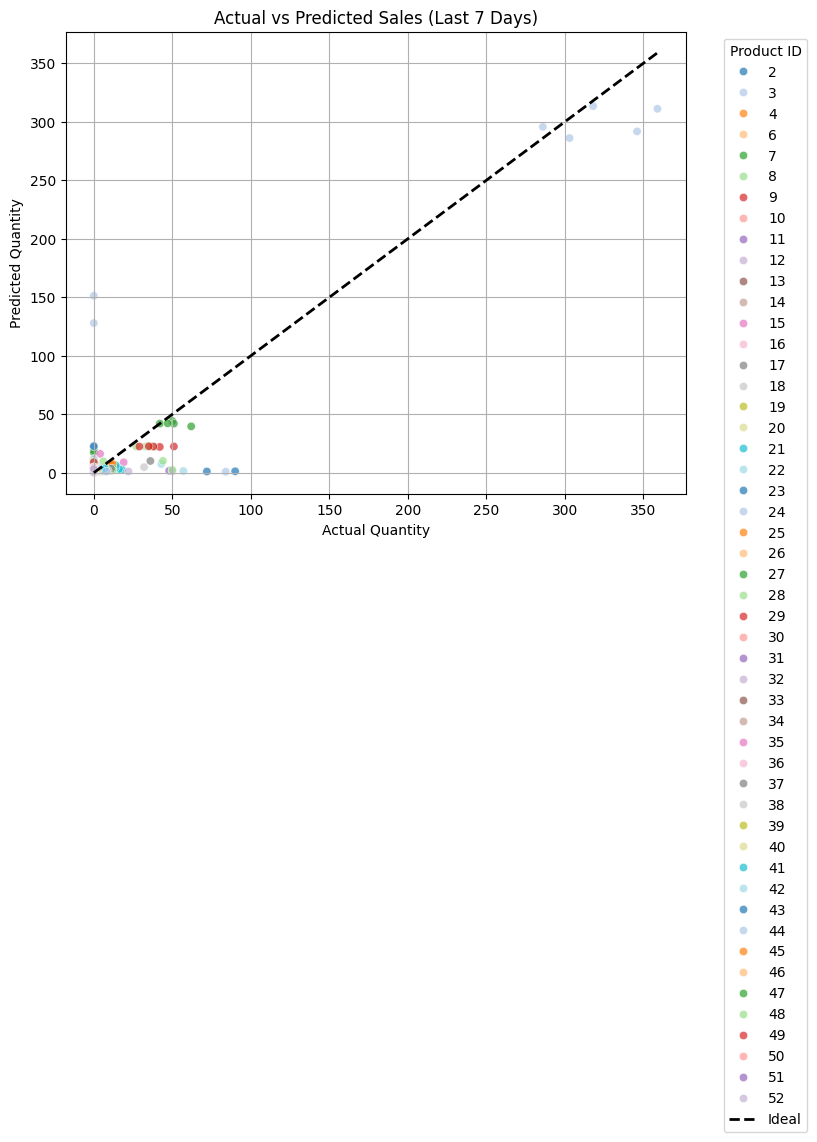

In [ ]:
# Train model with best parameters
best_params = {
    'colsample_bytree': 0.6,
    'learning_rate': 0.105,
    'max_depth': 3,
    'n_estimators': 50,
    'subsample': 0.7,
    'random_state': 42
}

model = XGBRegressor(**best_params)

# Define features and target
features = df_daily_sales.drop(columns=['quantity', 'date', 'product_name'])
target = df_daily_sales['quantity']

# Use the last 7 days for testing
last_date = df_daily_sales['date'].max()
test_mask = df_daily_sales['date'] > (last_date - pd.Timedelta(days=7))

X_train = features[~test_mask]
y_train = target[~test_mask]
X_test = features[test_mask]
y_test = target[test_mask]

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Create comparison dataframe
df_pred = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred,
    'product_id': df_daily_sales.loc[test_mask, 'product_id'].values
})

# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pred, x='actual', y='predicted', hue='product_id', palette='tab20', alpha=0.7)
plt.plot([df_pred['actual'].min(), df_pred['actual'].max()],
         [df_pred['actual'].min(), df_pred['actual'].max()],
         'k--', lw=2, label='Ideal')
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.title('Actual vs Predicted Sales (Last 7 Days)')
plt.legend(title='Product ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Base metrics
rmse = np.sqrt(mean_squared_error(df_pred['actual'], df_pred['predicted']))
mae = mean_absolute_error(df_pred['actual'], df_pred['predicted'])
r2 = r2_score(df_pred['actual'], df_pred['predicted'])

print(f"Global RMSE: {rmse:.4f}")
print(f"Global MAE: {mae:.4f}")
print(f"Global R²: {r2:.4f}")


Global RMSE: 16.1670
Global MAE: 6.3045
Global R²: 0.8368


## ✅ Conclusion

This project successfully developed a time-aware regression model to forecast daily product-level demand for a café specializing in Indian snacks. Using XGBoost and a series of engineered temporal and rolling features, we predicted quantities sold over the final 7-day period of the dataset.

Key evaluation metrics were:

- **RMSE**: 16.17  
- **MAE**: 6.30  
- **R²**: 0.837  

These figures indicate the model captures the majority of sales variation and performs reasonably well in aggregate. However, the scatter plot of actual vs. predicted quantities reveals that the model tends to underperform on extreme cases—particularly where sales volumes spike.

This limitation is critical in practice: underpredicting during peak days could lead to stockouts, while overpredicting inflates inventory costs. Thus, while the model is a strong baseline, future iterations should address:

- **Outlier robustness** through quantile regression or gradient boosting with asymmetric loss
- **Contextual feature inclusion** (e.g., holidays, weather, marketing events)
- **Per-product model tuning**, as product behaviors vary

Overall, this model serves as a valuable starting point for inventory planning and sales forecasting. With further refinement, it can evolve into a decision-support tool for operational efficiency in café management.